### **Langgraph Tool 활용 기초** ###

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "YOUR_API_KEY"

In [111]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

#### **Langgraph Custom Tool 선언** ####

In [113]:
#langchain_core.tools의 tool을 import하면 @tool 데코레이터만으로 함수를 langchain의 tool로 변환할 수 있습니다.
#아래 날씨 관련 함수들은 임의의 로직이므로, 실제 함수는 API를 포함한 로직이 들어가면 됩니다.
@tool
def get_weather(location: str):
    """Call to get the weather"""
    if location in ["서울", "인천"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."

@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "서울, 고성"

In [115]:
#Tool Node로 묶어줄 때, 리스트 형태로 tool들을 함께 제공합니다.
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [ ]:
#bind_tools() 함수로 LLM에게 어떤 tool들이 있는지 인지시켜 도구를 활용하도록 만듭니다.
from langchain_openai import ChatOpenAI

model_with_tools = ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).bind_tools(tools)

In [127]:
model_with_tools.invoke("서울 날씨는 어때?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_HmyqZSrjgHd0p59ePE1Ll9kZ',
  'type': 'tool_call'}]

In [125]:
model_with_tools.invoke("한국에서 가장 추운 도시는?").tool_calls

[{'name': 'get_coolest_cities',
  'args': {},
  'id': 'call_lt9B0z9aILHS2HHJCyId5F7G',
  'type': 'tool_call'}]

In [129]:
tool_node.invoke({"messages": [model_with_tools.invoke("서울 날씨는 어때?")]})

{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='call_k7S04S37SUlIhe5jdyw9zJIb')]}

#### **노드, 엣지를 선언하고 그래프 정의하기** ####

In [131]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState

def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

# add_conditional_edges는 조건부 엣지 추가 함수입니다.
#아래 conditional_edge는 should_continue라는 함수에 따라 agent 노드에서 tool 혹은 end로 진입시킵니다.
# def should_continue(state: MessagesState) -> Literal["tools", END]:
#     messages = state['messages']
#     last_message = messages[-1]
#     # If the LLM makes a tool call, then we route to the "tools" node
#     if last_message.tool_calls:
#         return "tools"
#     # Otherwise, we stop (reply to the user)
#     return END

workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", 'agent')

app = workflow.compile()

#### **그래프 시각화** ####

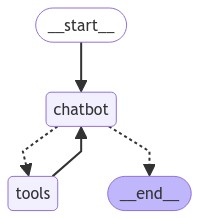

In [133]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

#### **invoke 함수로 그래프 호출하기** ####

In [135]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어때?")]}
)
final_state["messages"][-1].content

'서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다.'

In [137]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "가장 추운 도시의 날씨는 어때?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

가장 추운 도시의 날씨는 어때?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_KVq9iOM6UMURVnYj2VvydHid)
 Call ID: call_KVq9iOM6UMURVnYj2VvydHid
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

서울, 고성
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_o7SnhRLJXxugmPw1UNseAcfE)
 Call ID: call_o7SnhRLJXxugmPw1UNseAcfE
  Args:
    location: 서울
  get_weather (call_OaKLeEcLz2PgxMusCjMaxQsf)
 Call ID: call_OaKLeEcLz2PgxMusCjMaxQsf
  Args:
    location: 고성
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 60도(약 15도)로 안개가 끼어 있습니다. 반면, 고성의 날씨는 90도(약 32도)로 맑